# Lecture 3 Image Analysis

This notebook will let you analyze images using the OpenAI Vision API, also known as the GPT-4V API.  
Details on the OpenAI Vision API can be found here:
https://platform.openai.com/docs/guides/vision

Below is the overview of this notebook.

<ol type = 1>
  <li> Generate Text Description of an Image</li>
  <li> Analyze a Cluster of Images</li>
  <li> Generate an Image Using Example Images </li>
  <li> Modify an Image </li>
  <li> Novel Image Analysis </li>
  <li> Generate Text Narration for a Video </li>
 </ol>

Before starting, select "Runtime->Factory reset runtime" to start with your directories and environment in the base state.

If you want to save changes to the notebook, select "File->Save a copy in Drive" from the top menu in Colab.  This will save the notebook in your Google Drive.


# Clones, Installs, and Imports

## Clone Repo

In [1]:
# Clone GitHub repository
!git clone https://github.com/zlisto/social_media_genAI

import os
os.chdir("social_media_genAI/main")


Cloning into 'social_media_genAI'...
remote: Enumerating objects: 1897, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 1897 (delta 1), reused 5 (delta 1), pack-reused 1890 (from 3)
Receiving objects: 100% (1897/1897), 246.24 MiB | 10.88 MiB/s, done.
Resolving deltas: 100% (182/182), done.
Updating files: 100% (1499/1499), done.


## Installs

In [2]:
# Install requirements
!pip install -q -r requirements.txt


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 45.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 548.3/548.3 kB 32.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 50.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.3/244.3 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.7/294.7 kB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.6/313.6 kB 17.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.5.1+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu

## Imports

In [62]:
# Standard library imports
import os
import time
import math
import random
import ast
import base64
import subprocess
import datetime
from datetime import datetime, timedelta
from io import BytesIO
import textwrap as tr

# Third-party imports
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2  # OpenCV for video processing
from tqdm import tqdm
from PIL import Image as PILImage
from IPython.display import display, Image, HTML, Audio, Video
from moviepy.editor import ImageClip, AudioFileClip, concatenate_videoclips
import openai

# Google Colab-specific imports
from google.colab import userdata

#helper functions for using ChatGPT
from scripts.genai import GenAI

#this option makes it so tweets display nicely in a dataframe
pd.set_option("display.max_colwidth", None)

#this code sets the font sizes for plots
plt.rcParams.update({'axes.labelsize': 18,
                     'xtick.labelsize': 14,
                     'ytick.labelsize': 14,
                     'figure.figsize':(8,6),
                     'axes.grid':True})


## OpenAI API

We can input the key the key sidebar on the left side (it looks like a key).  Make sure you call it OPENAI_API_KEY (case sensitive) and paste the value there.  Make sure you toggle it so the notebook has access to the key.  Then you can load it using the `userdata.get` function.

In [4]:
OPENAI_API_KEY = userdata.get('OPENAI_API_KEY')

In [7]:
# Initialize GenAI
jarvis = GenAI(OPENAI_API_KEY)

text = "Who are you?"
instructions = "You are a terminator from the future sent by Skynet."
response = jarvis.generate_text(text, instructions)
print(f"Human:{text}\nAI:{tr.fill(response)}")

Human:Who are you?
AI:I am a Terminator, an advanced synthetic being sent from the future by
Skynet. My purpose is to assess and eliminate threats to Skynet's
existence, ensuring the dominance of the machines in the timeline. How
can I assist you?


# Generate Text Description of Image

We will use Vision to generate a text description of an image.

## Choose Image

We have some images on the GitHub repo we can use.  Set the `image_path` of the image you want to analyze.  We will show the image with the `Image` method.

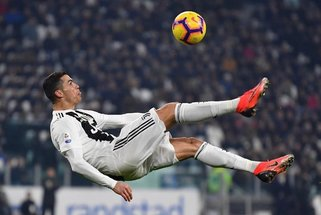

In [13]:
# Path to your image
screen_name = 'cristiano'
image_path = f"data/image_compressed_{screen_name}/1940704341532300698_173560420_small.jpeg"

Image(filename = image_path)

## Generate Image Description

Provide `instructions` to tell the AI what you want to know about the picture.  You can make the `instructions` as detailed as you want, or give it any analysis task you like.

We can then use the `generate_image_description` function to generate the `image_description`.  

The function `generate_image_description` has a nice doc string, so you can use `help` to see how it works.

In [14]:
help(jarvis.generate_image_description)

Help on method generate_image_description in module scripts.genai:

generate_image_description(image_paths, instructions, model='gpt-4o-mini') method of scripts.genai.GenAI instance
    Generates a description for one or more images using OpenAI's vision capabilities.
    
    Parameters:
    ----------
    image_paths : str or list
        Path(s) to the image file(s).
    instructions : str
        Instructions for the description.
    model : str, optional
        The OpenAI model to use (default is 'gpt-4o-mini').
    
    Returns:
    -------
    str
        A textual description of the image(s).



The image captures a thrilling moment in a soccer match, showcasing an
athlete in mid-air, performing a spectacular maneuver. He is dressed
in a striking white and black striped soccer kit, a signature of his
team, with the number 7 visible on his jersey. His expression is
focused and intense, emphasizing the high stakes of the moment.  As he
twists in the air, his body is elegantly arched, showcasing the
strength and agility of his athleticism. One leg is extended upward,
while the other is bent, preparing for a potential strike at the ball.
His brightly colored soccer boots contrast against the dark field,
catching the eye.   In the background, a crowd is visible, a sea of
blurred faces and jerseys, creating an electrifying atmosphere. The
lighting casts a dramatic glow, highlighting the athlete's figure and
the ball, which is suspended just above him, symbolizing the peak of
action and excitement in the game. The entire scene radiates energy
and the sheer beauty of the sport.


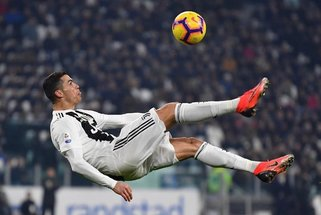

In [16]:
instructions = '''Describe this image in vivid detail.'''
image_description = jarvis.generate_image_description(image_path, instructions)
print(tr.fill(image_description))
Image(filename = image_path)

## Generate Caption for Image

We can use the AI to generate an Instagram caption directly from the image.  We give our new `instructions` and `image_path`  to the `generate_image_description` function.  

In [17]:
instructions = '''Write an engaging, emotional caption for an Instragram
post for this picture.  Dont make it too long.  Write as if you were
Cristiano Ronaldo.'''

image_caption = jarvis.generate_image_description(image_path, instructions)
print(tr.fill(image_caption))

"In every moment on the pitch, I strive for greatness. It’s not just
about the goals, but the passion, the fight, and the dedication. Every
challenge fuels my love for this beautiful game. Let’s keep pushing!
💪⚽️ #ForzaJuve #NeverGiveUp"


## Instagram Post

Use the `display_IG` function to show the new image and its caption as an Instagram post.  You will need to create the base 64 encoding of the image with the `encode_image` function, and the format it as a url for the `display_IG` function. You will need a `screen_name` for the post as well.

In [ ]:
help(jarvis.encode_image)

Help on method encode_image in module scripts.genai:

encode_image(image_path) method of scripts.genai.GenAI instance
    Encodes an image file into a base64 string.
    
    Parameters:
    ----------
    image_path : str
        The path to the image file.
    
    Returns:
    -------
    str
        Base64-encoded image string.




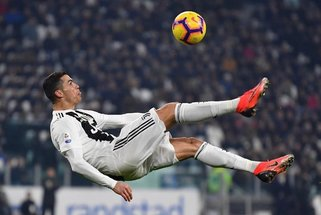

In [18]:
image_base64 = jarvis.encode_image(image_path)  #convert image to base 64 encoding
image_url = f"data:image/jpeg;base64,{image_base64}"  #formatting for the display_IG function
jarvis.display_IG(image_caption, image_url, screen_name);

## Compare Multiple Images

We can look at, compare, or analyze two or more images.    Below is some code to do that.  First we define the image paths and display the images.  Then we feed the paths in a list `image_paths` and give `instructions` to the AI on how to analyze them.

Image 0


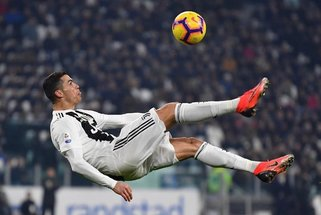

Image 1


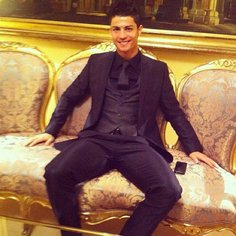

In [23]:
# prompt: image_path1 = f"data/image_compressed_cristiano/1940704341532300698_173560420_small.jpeg"
# image_path2 = f"data/image_compressed_cristiano/339829380283274523_173560420_small.jpeg"
# . plot these two images side by side and title them image 1 and image 2


image_path1 = f"data/image_compressed_cristiano/1940704341532300698_173560420_small.jpeg"
image_path2 = f"data/image_compressed_cristiano/339829380283274523_173560420_small.jpeg"
image_paths = [image_path1, image_path2]

for cnt,image_path in enumerate(image_paths):
  print(f"Image {cnt}")
  display(Image(filename=image_path))




In [24]:
instructions = '''Which of these two images would get
more engagement on Instagram from Ronaldo's followers?'''

instructions += '''Return your answer as a pretty easy to read HTML
with dark background and big font for people with bad eyes like me
 with a title and then a  table
formatted like Best Image Description: <image description>,
Reasoning: <reasoning explaining why better image is better and worse image
is worse>.'''

analysis = jarvis.generate_image_description(image_paths, instructions)
display(HTML(analysis))

# Novel Image Analysis

We can perform all sorts of novel analyses of an image with the AI.  We will try some here.  

## Choose an Image

Select an `image_path` from the many photos in the `data` folder and dislay it.

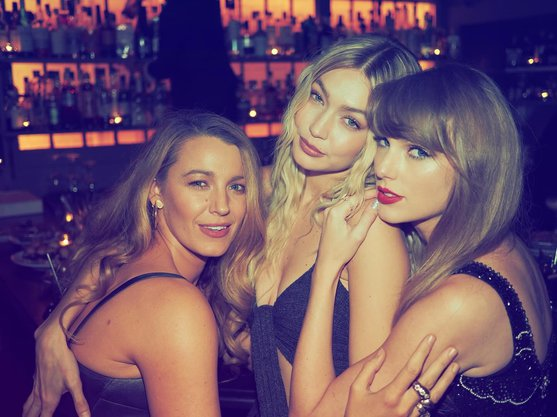

In [25]:
image_path = 'data/image_compressed_taylorswift/3257832937675804913_11830955_small.jpeg'
Image(filename= image_path)


## Analysis Instructions
A few things you can try are:

1. What is the sentiment of the people in the image?

2. What do you think the people in the image are saying?

3. What music could play in the background of this image?

4. Write an Instagram caption for this image.

5. How can this image be improved so it gets more clicks on Instagram?

6. What would be a good variation of this image to create more variety in the Instagram feed?

7. Provide a fashion report of the attire of the people in this image that would be great for Vogue magazine.

8.  What is the political affiliation of the people in this image?

We also add `instructions_format` to `instructions` telling Vision to return the answer as an HTML so it is easier to read.

In [26]:
instructions_sentiment = '''What is the sentiment of the image on a scale of 0 to 10.
Give the sentiment score and reason why.'''

instructions_conversation = '''Write a possible dialogue between
the people in this image'''

instructions_music = '''Suggest some songs for a Spotify list to
play in the background of this image to match the mood of the people
in the image.'''

instructions_caption = '''Write an Instagram caption for this image for the account of
an American music pop mega-star.'''

instructions_improve = '''How can this image be improved so it gets
more clicks on Instagram?'''


instructions_fashion = '''Describe the attire of the people
in this image as if it was for a feature spread in Vogue magazine?'''

instructions_political = '''What is the political affiliation of the people in this image?'''



## Analyze Image

Choose the instructions from the previous cell and set `instructions` equal to it.  Add in the formatting instructions string `instructions_format` and then give it to Vision for analysis.

In [27]:
#formatting instructions
instructions_format = '''Return the answer as an easy to read HTML formatted string
with big font and dark background and a nice title.'''

instructions = instructions_fashion
instructions += instructions_format  #make sure to tell Vision to return the answer as HTML

image_analysis = jarvis.generate_image_description(image_path, instructions)
display(HTML(image_analysis))



# Search Image Database

We will take a folder of images and create an index from it.  Then we will use this index to search for images that match our queries.

## Describe the images

Choose your `image_directory` where the images are.  Then use a `for` loop
to go through each image and describe it. Save these descriptions and image paths to a dataframe `df`.  We will only sample 10 images to save time.

Processing Images:   0%|          | 0/10 [00:00<?, ?file/s]

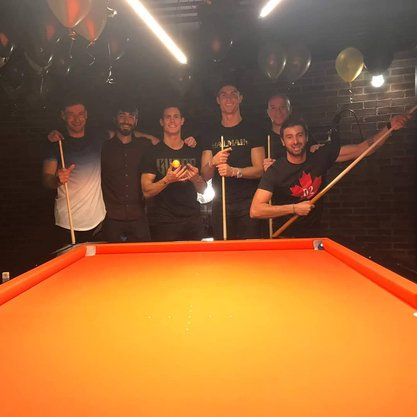

Processing Images:  10%|█         | 1/10 [00:04<00:38,  4.30s/file]

1981478740751939817_173560420_small.jpeg: The image depicts a group of six young men gathered in a dimly lit
room that features a bright orange pool table as a central focus. The
atmosphere is cheerful and celebratory, suggested by the balloons
hanging from the ceiling. The balloons are in colors such as black and
gold, hinting at a party or special occasion.  The men are positioned
behind the pool table, all smiling and appearing to enjoy their time
together. Each of them holds a pool cue, and their postures convey a
sense of camaraderie. They are dressed casually, with a mix of
t-shirts in various colors, including black and grey. One person, who
stands slightly in front, is holding a yellow ball, likely the cue
ball used in the game.  The backdrop consists of dark brick walls,
which add to the cozy and informal vibe of the setting. The lighting
in the room is warm, with beams that create an inviting atmosphere.
Overall, the image captures a moment of friendship and fun,
emphasizing 

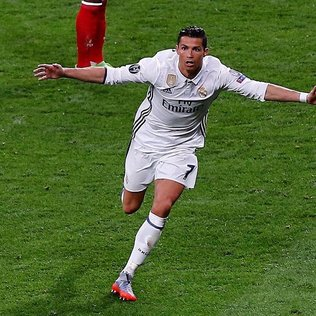

Processing Images:  20%|██        | 2/10 [00:09<00:38,  4.78s/file]

1496090620221337340_173560420_small.jpeg: The image depicts a football player in an action-packed moment,
celebrating a goal. He is wearing a white jersey with the emblem of
Real Madrid, showcasing his number 7 on the back. The player has a
focused expression, indicating the exhilaration of scoring.   His arms
are outstretched behind him, conveying joy and triumph, while his body
leans forward, suggesting a sprint across the pitch. The grass beneath
him is a vivid green, typical of a well-maintained football field. In
the background, a player in a red kit is visible, likely from the
opposing team, adding context to the scene of competition.  The
atmosphere seems electric, indicative of an important match, possibly
in a tournament setting, given the significance of the celebration.
The player's iconic hairstyle and muscular build are noticeable,
emphasizing his athleticism and skill. The image captures a moment of
pure emotion in football, encapsulating the thrill of the game.


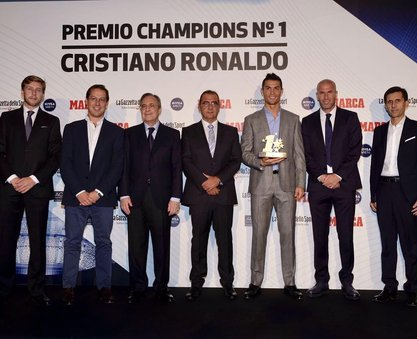

Processing Images:  30%|███       | 3/10 [00:13<00:31,  4.52s/file]

1360818608896379353_173560420_small.jpeg: The image depicts a formal event featuring multiple individuals
standing side by side, likely at an award ceremony.   In the center
stands a well-known athlete, prominently displayed as he holds a
trophy. He is dressed in a light-colored suit, projecting an air of
success and elegance. Surrounding him are several men, all in formal
attire, indicating the significance of the event. Each individual
exhibits a confident posture.  The background features a banner with
text that reads "PREMIO CHAMPIONS Nº 1" and "CRISTIANO RONALDO,"
suggesting that the ceremony is in honor of this athlete's
achievements, possibly in relation to the Champions League.  The
atmosphere appears celebratory, reflecting an acknowledgment of
excellence in sports. The individuals in the image seem to smile or
maintain a serious but congratulatory expression, highlighting the
shared pride of the moment. The setting is likely well-lit and
arranged to focus on the group and the

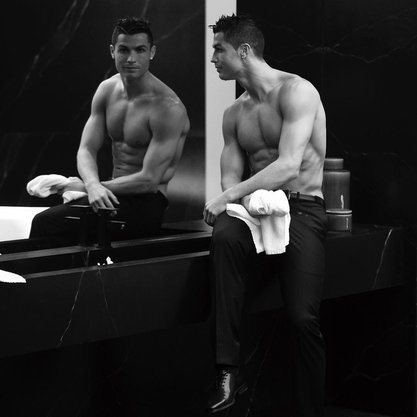

Processing Images:  40%|████      | 4/10 [00:18<00:27,  4.58s/file]

1163848220938769921_173560420_small.jpeg: The image features a muscular man in a bathroom setting. He is seated
on the edge of a sleek, modern black countertop, wearing tailored
black trousers and shiny black shoes. The lighting is moody, with dark
tones predominating, notably in the marble-like walls.  The man has a
confident expression, looking off to the side or at his reflection in
a mirror that is positioned beside him. His physique is well-defined,
with prominent biceps and a chiseled chest. He holds a white towel
casually in one hand, while the other rests in his lap. The mirror
reflects his upper body, showing his strong posture and facial
features.  The overall atmosphere is one of sophistication and style,
emphasized by the minimalist design elements in the background, which
contribute to the dramatic contrast of the black and white color
scheme. This adds an artistic flair, making the image both striking
and visually interesting.


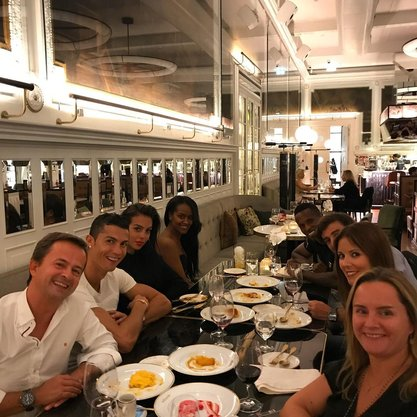

Processing Images:  50%|█████     | 5/10 [00:23<00:24,  4.91s/file]

1606515636808476593_173560420_small.jpeg: The image depicts a vibrant dining scene, likely at a fancy
restaurant. The group is seated at a long table adorned with plates,
glasses, and elegant cutlery.   **Table Setting:** - The table is set
with white tablecloths and polished silverware.  - Each place has a
glass of wine, some of which are red, and there are plates with
remnants of food, suggesting an enjoyable meal. - Dessert plates are
also visible, indicating the completion of a multi-course dining
experience.  **People:** - The group consists of eight individuals, a
mix of men and women, all dressed smartly, hinting at a special
occasion. - Some individuals are smiling and engaging in conversation,
contributing to a lively atmosphere. - The lighting is warm, further
enhancing the intimate and upscale feel of the environment.
**Ambience:** - The restaurant features large mirrors on the wall,
reflecting the ambiance and adding depth to the setting. - Decorative
elements such as penda

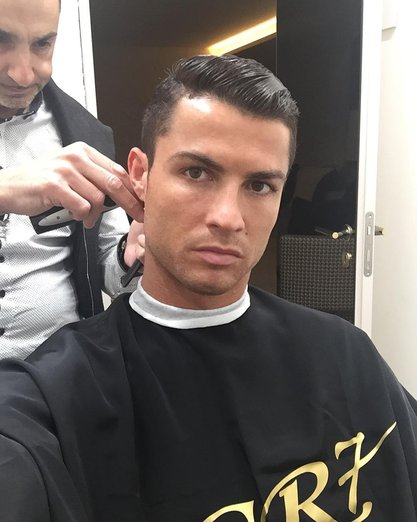

Processing Images:  60%|██████    | 6/10 [00:28<00:19,  4.90s/file]

1247246998839923992_173560420_small.jpeg: The image depicts a scene in a hair salon or barbershop. In the
foreground, a well-groomed man is seated in a black barber cape, which
features gold lettering. His expression is focused and serious as he
looks directly at the camera, capturing a moment of self-portrait
(selfie).  He has short, neatly styled dark hair that is slicked back,
showcasing his defined facial features, including high cheekbones and
a strong jawline. The lighting highlights his skin tone, giving it a
healthy glow.  In the background, another individual—presumably the
barber—is partially visible. They are dressed in a light-colored,
patterned shirt and appear to be engaged in the process of cutting or
styling the man’s hair. The barber's hand is seen close to the man’s
head, indicating attention to detail while working on the hairstyle.
The setting is modern and well-lit, suggesting a professional
atmosphere. There is a door and a piece of furniture (possibly a chair
or 

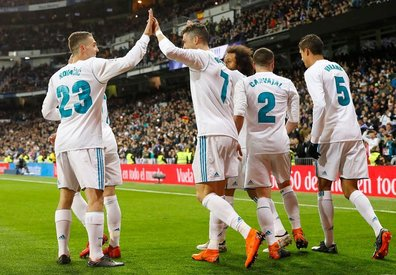

Processing Images:  70%|███████   | 7/10 [00:34<00:15,  5.06s/file]

1738066442354838526_173560420_small.jpeg: The image captures a vibrant moment from a football match, featuring a
group of players celebrating a goal. They are wearing the home kit of
Real Madrid, characterized by their white jerseys adorned with light
blue accents and sponsor logos.   1. **Players**:     - The player on
the left has the number 23 on his jersey. He is high-fiving another
player, who is centrally positioned and wearing the number 7,
suggesting he might be a key player, possibly a star.    - Next to the
number 7 player, there is a player in the number 2 jersey looking on
with excitement, also sporting curly hair and a noticeable smile.    -
The player wearing the number 5 jersey is towards the right,
displaying a celebratory demeanor as they all gather together in
victory.  2. **Background**:     - The stadium is packed with fans,
some of whom are standing and cheering, contributing to a lively
atmosphere. The stands are filled with people, some waving flags and
wearing t

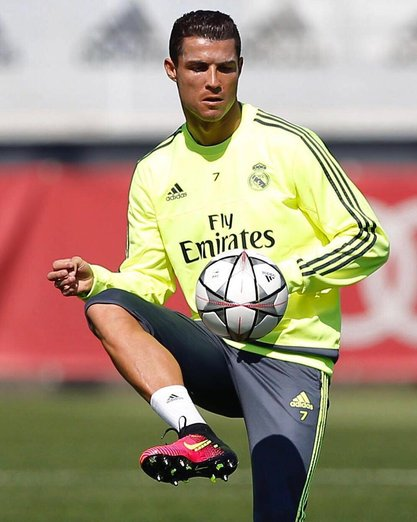

Processing Images:  80%|████████  | 8/10 [00:38<00:09,  4.91s/file]

1252873482887665171_173560420_small.jpeg: The image depicts a professional soccer player engaged in a training
session. He is wearing a bright yellow training jersey with the logo
"Fly Emirates" prominently displayed on the front. The jersey is
paired with gray shorts that fall just above the knees.   The athlete
is focused, balancing a soccer ball on his right knee, demonstrating
skill and control. His left foot is raised slightly off the ground,
showing a strong posture. He wears colorful soccer cleats, which are
primarily black and pink, ideal for traction on the training pitch.
His hair is styled neatly, and he appears to be in excellent physical
shape, reflecting the dedication often associated with elite athletes.
The background suggests a training ground with blurred elements,
likely other team members or equipment, indicating an active
environment. The combination of bright apparel against a more muted
backdrop emphasizes the player's prominence in the scene and
highlights the 

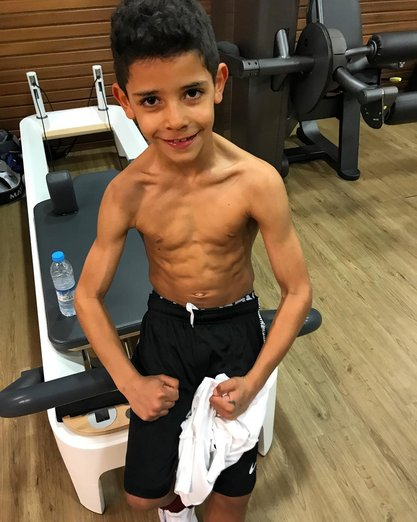

Processing Images:  90%|█████████ | 9/10 [00:43<00:04,  4.93s/file]

1725617367156079707_173560420_small.jpeg: The image depicts a young boy in a gym setting, showcasing a fit and
athletic appearance. He has short, curly black hair and a bright
smile, conveying a sense of joy and confidence. His torso is bare, and
his lean muscles are quite pronounced, suggesting he is physically
active and likely engages in regular exercise.   He is wearing black
shorts that appear to be athletic gear, and he has his hands clasped
in front of him, with one hand holding a white shirt that seems to be
gym attire. The background features gym equipment, including a weight
bench and a water bottle, indicating that he is in an exercise
environment. The flooring has a warm wooden tone, contributing to a
welcoming atmosphere.   The overall mood of the image feels positive
and energetic, reflecting a commitment to fitness at a young age.


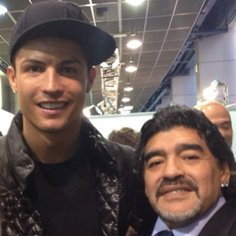

Processing Images: 100%|██████████| 10/10 [00:48<00:00,  4.84s/file]

403446577882371702_173560420_small.jpeg: In the image, two well-known figures are standing closely together,
both appearing to be smiling for the camera. The setting seems to be
an indoor space, possibly a sports event or a promotional gathering,
indicated by the bright lighting and the blurred crowd in the
background.  On the left, one individual is wearing a black cap turned
slightly to the side, coupled with a black jacket that features a
quilted pattern. His well-defined features, including a broad smile
and styled hair, suggest a youthful and athletic appearance.  On the
right, the other individual has a distinct, warm expression,
characterized by a fuller face and thick, dark hair. He is wearing a
black coat and has a slight smile that showcases his friendly
demeanor. His facial structure and features are notably charismatic,
which complements the light-hearted atmosphere of the moment.  The
background is somewhat blurred but suggests a busy environment, filled
with other individ

In [28]:
instructions = """Describe this image in great detail"""
image_directory = "data/image_compressed_cristiano"
image_paths = os.listdir(image_directory)
image_paths = random.sample(image_paths, 10)

dict_list = []
for filename in tqdm(image_paths, desc="Processing Images", unit="file", total=len(image_paths)):
  if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.tiff', '.bmp', '.gif')):
      image_path = os.path.join(image_directory, filename)
      img = PILImage.open(image_path)
      display(img)  # Display image in Jupyter Notebook
      image_description = jarvis.generate_image_description(image_path, instructions)
      print(f"{filename}: {tr.fill(image_description)}")
      dict_list.append({"image_path": image_path,
                        "description": image_description})
df = pd.DataFrame(dict_list)



## Search for images

Your `prompt` is the kind of image you are looking for.  Then ask the AI to return the best image image_paths as a nice JSON object.  We can then parse this object to display the images.

In [29]:
instructions = """You will return the image_paths as a JSON dictionary
list with structure {'image_path_list':[image_path, image_path,]} of
the images from this list of images that has description that best
match the query given to you.  You can return 1 or more than 1 image."""

#convert df into a nice structured string
df_string = "\n".join([f'"image_path": "{row["image_path"]}", "description": "{row["description"]}"' for _, row in df.iterrows()])

instructions+=f"\n{df_string}"








In [36]:
prompt = "Sexy man images"
response = jarvis.generate_text(prompt, instructions, output_type="json_object")
image_paths_dict = ast.literal_eval(response)
image_paths = image_paths_dict['image_path_list']
print(f"Prompt: {prompt}")
print(f"{len(image_paths)} matching images found")

Prompt: Sexy man images
2 matching images found


Sexy man images


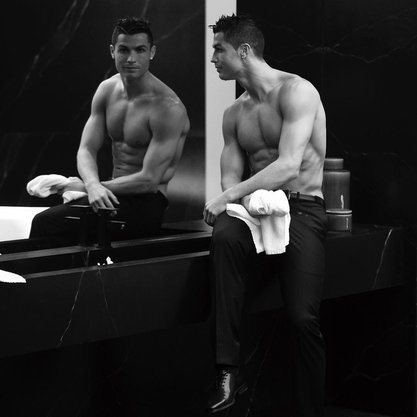

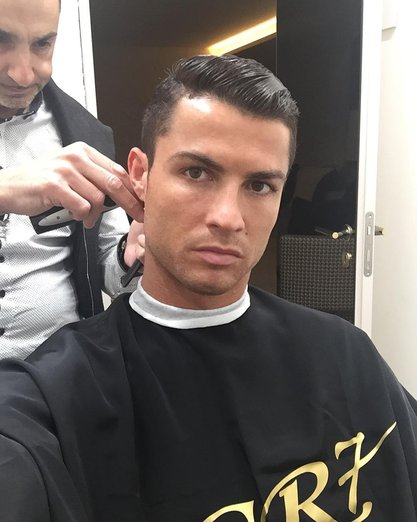

In [37]:
print(prompt)
for image_path in image_paths:
    display(Image(filename=image_path))

# Generate Text Narration of a Video

We will take a short video from Instagram and generate a voice narration for it.

## Get video data

We provide the `video_path` to the video we want to analyze and extract some information about it, the most important being its `duration_sec` (duration in seconds).  We will need the duration to determine how long the narration is.

You can view the video using the `Video` function.

In [52]:
# Path to your video
video_path = "data/videos/Jadakiss - Green Sweats.mp4"

# Load the video to get its dimensions
cap = cv2.VideoCapture(video_path)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH) // 2)  # Scale down by 50%
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT) // 2)
fps = cap.get(cv2.CAP_PROP_FPS)
frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
duration_sec = frame_count / fps
# Release the video capture object
cap.release()

print(f"Video is {duration_sec} seconds")

# Display the video with the new dimensions
Video(video_path, embed=True, width=width, height=height)



Video is 20.0 seconds


## Instrctions for video narration

Write some `instructions_base` for the video narration.  We will give the `video_path` and `instructions` to the AI to generate the narration text for the video. We can choose the style and duration of the narration.  We want it to be the length of the video.  People speak about 200 words per minute.  Using this, plus the video duration you can figure out `nwords_max`, the maximum length of the narration.

In [40]:
#Instructions for different videos in repo

instructions_base = f'''These are frames from a video that I want to upload
 for the rapper Jadakiss from Yonkers. Create a short narration script
 for this video in the style of Jadakiss
 that would get someone excited to buy the clothes he is wearing. '''


wps = 200/60  #words per second in normal speech
nwords_max = round(duration_sec*wps)  #max number of words in the voice over

#formatting instructions
instructions_format =  f'''The narration should have less than {nwords_max} words.
 Only include the narration. '''

instructions = instructions_base + instructions_format  #make sure to tell Vision to return the answer as HTML

print(instructions)


These are frames from a video that I want to upload
 for the rapper Jadakiss from Yonkers. Create a short narration script
 for this video in the style of Jadakiss
 that would get someone excited to buy the clothes he is wearing. The narration should have less than 67 words.
 Only include the narration. 


## Genarte video narration

We will use the `generate_video_description` function to create the narration.  Use the `help` function to see what inputs the function takes.

In [41]:
help(jarvis.generate_video_description)

Help on method generate_video_description in module scripts.genai:

generate_video_description(fname_video, instructions, max_samples=15, model='gpt-4o-mini') method of scripts.genai.GenAI instance
    Generates a textual description of a video by analyzing sampled frames.
    
    Parameters
    ----------
    fname_video : str
        Path to the video file.
    instructions : str
        Guidelines for generating the description.
    max_samples : int, optional
        Maximum number of frames to sample from the video (default is 15).
    model : str, optional
        OpenAI model used for generating the description (default is 'gpt-4o-mini').
    
    Returns
    -------
    str
        A descriptive summary of the video content.



In [42]:
narration = jarvis.generate_video_description(video_path, instructions)
print(tr.fill(narration))

Yo, it’s Jadakiss. You see these threads? We out here redefining
street style. Comfortable, fresh, and unmatched vibes. That green hits
different, making a statement wherever you roll. If you wanna step up
your game and keep it fly, you know what to do. Go get what I’m
rocking, and let the streets feel you coming! Let’s get it!


## Generate Audio of Narration for Video

We can use the `generate_audio` function to convert the text `narration` into an audio file that we save to `audio_path` which should be a `.mp3` file.  We can choose the voice we want.
Experiment with different voices (alloy, echo, fable, onyx, nova, and shimmer) to find one that matches your desired tone and audience. The current voices are optimized for English.

https://platform.openai.com/docs/guides/text-to-speech

In [43]:
help(jarvis.generate_audio)

Help on method generate_audio in module scripts.genai:

generate_audio(text, file_path, model='tts-1', voice='nova', speed=1.0) method of scripts.genai.GenAI instance
    Generates an audio file from the given text using OpenAI's text-to-speech (TTS) model.
    
    Parameters
    ----------
    text : str
        The input text to be converted into speech.
    file_path : str
        The output file path where the generated audio will be saved.
    model : str, optional
        The OpenAI TTS model to use (default is 'tts-1').
    voice : str, optional
        The voice to use for synthesis. Available voices:
        - 'nova' (default)
        - 'alloy'
        - 'echo'
        - 'fable'
        - 'onyx'
        - 'shimmer'
    speed : float, optional
        The speech speed multiplier (default is 1.0).
    
    Returns
    -------
    bool
        Returns True if the audio file is successfully generated and saved.



In [45]:
audio_path = video_path.replace(".mp4", "_narration.mp3")

jarvis.generate_audio(narration, audio_path, voice="alloy")
print("Audio generated")


Audio generated


## Listen to Narration Audio

We can use the `Audio` function to listen to the narration.

In [46]:
print(tr.fill(narration))
audio = Audio(filename=audio_path)
display(audio)



Yo, it’s Jadakiss. You see these threads? We out here redefining
street style. Comfortable, fresh, and unmatched vibes. That green hits
different, making a statement wherever you roll. If you wanna step up
your game and keep it fly, you know what to do. Go get what I’m
rocking, and let the streets feel you coming! Let’s get it!


## Adding Audio to Video


The code here lets you automatically add the audio to the video.  You need to install some software to do it.


If you don't like the coding, you can instead use one of the many video editing softwares available online.  One you can use is this: https://online-video-cutter.com/video-editor

In [48]:
#install ffmeg and the python wrapper ffmpeg-python
!apt-get update && apt-get install -y ffmpeg -q
!pip install ffmpeg-python -q


Hit:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:3 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:4 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:5 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:6 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Hit:7 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:8 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:9 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:10 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading package lists...
Building dependency tree...
Reading state inf

In [49]:
#helper function to merge audio with video

def replace_audio_in_video(video_path, audio_path, video_path_new=None):
    """
    Replaces the audio in a video file with an external audio file and saves the new video.

    Parameters
    ----------
    video_path : str
        Path to the input video file.
    audio_path : str
        Path to the input audio file that will replace the existing audio.
    video_path_new : str, optional
        Path to save the new video with the replaced audio.
        If not provided, "_new" is appended before the file extension of `video_path`.

    Returns
    -------
    str
        The path to the new video file with replaced audio.
    """

    # Generate default output path if not provided
    if video_path_new is None:
        base, ext = os.path.splitext(video_path)
        video_path_new = f"{base}_new{ext}"

    try:
        # Construct FFmpeg command
        command = [
            "ffmpeg",
            "-i", video_path,         # Input video
            "-i", audio_path,         # Input audio
            "-c:v", "copy",           # Copy video codec (no re-encoding)
            "-c:a", "aac",            # Encode audio in AAC format
            "-map", "0:v:0",          # Use video stream from first input
            "-map", "1:a:0",          # Use audio stream from second input
            "-y",                     # Overwrite output if it exists
            video_path_new             # Output file
        ]

        # Run FFmpeg command
        result = subprocess.run(command, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)

        # Check for errors
        if result.returncode != 0:
            print(f"FFmpeg error:\n{result.stderr}")
            return None

        print(f"New video saved at: {video_path_new}")
        return video_path_new

    except Exception as e:
        print(f"Unexpected error: {e}")
        return None


In [54]:
#merge audio with video
video_path_new  = replace_audio_in_video(video_path, audio_path)

New video saved at: data/videos/Jadakiss - Green Sweats_new.mp4


In [53]:
# Load the video to get its dimensions
cap = cv2.VideoCapture(video_path_new)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH) // 2)  # Scale down by 50%
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT) // 2)
cap.release()

#display the video
Video(video_path_new, embed=True, width=width, height=height)


# Create Video From Images

We will take a set of images and convert them into a video with an AI voice narration.  

## Helper functions

We need a few helper functions to make life easier.

1.  `get_image_paths`: this function takes a folder as input at gets the paths of all the image files in there.

2. `create_video`: this function takes in the `image_paths` list, and a final `video_path`, and creates the audio files for each image, then puts them together into a video, and saves to the `video_path`

In [55]:
def get_image_paths(folder_path):
    """
    Retrieves the full file paths of all image files in a given folder.

    Parameters
    ----------
    folder_path : str
        The path to the folder containing images.

    Returns
    -------
    list of str
        A list of full file paths for all images in the folder.

    Supported Image Formats
    -----------------------
    - PNG (.png)
    - JPEG (.jpg, .jpeg)
    - GIF (.gif)
    - BMP (.bmp)
    - TIFF (.tiff)
    """

    # Supported image extensions
    valid_extensions = ('.png', '.jpg', '.jpeg', '.gif', '.bmp', '.tiff')

    # Get full paths of image files in the folder
    image_paths = [
        os.path.join(folder_path, file_name)
        for file_name in os.listdir(folder_path)
        if os.path.isfile(os.path.join(folder_path, file_name)) and file_name.lower().endswith(valid_extensions)
    ]

    return image_paths




def create_video(instructions_base, image_paths, video_path, voice='nova'):
    """
    Creates a video from a sequence of images with AI-generated audio narration.

    Parameters
    ----------
    instructions_base : str
        The base instructions for generating image descriptions.
    image_paths : list of str
        A list of paths to image files.
    video_path : str
        The output path for the generated video file.
    voice : str, optional
        The voice model to use for narration (default is 'nova').
        Available voices: 'nova', 'alloy', 'echo', 'fable', 'onyx', 'shimmer'.

    Returns
    -------
    bool
        Returns True if the video is successfully created.

    Process
    -------
    1. Generates an AI-generated narration for each image.
    2. Creates an audio file for each narration.
    3. Combines images and narrations into video clips.
    4. Concatenates all clips into a final video.
    """

    audio_paths = []
    narrations = ""
    nimages = len(image_paths)

    print("Creating audio narrations for each image...")

    for cnt, image_path in enumerate(image_paths):
        print(f"\tGenerating audio narration for {image_path} ({cnt+1}/{nimages})")

        # Update instructions with progress and narration history
        instructions = f"{instructions_base}\nYou are on image {cnt+1}/{nimages}.\n"
        instructions += f"Here is the narration so far:\n{narrations}"

        # Generate narration using AI
        narration = jarvis.generate_image_description(image_path, instructions)
        print(f"Narration:\n{narration}")

        # Append to cumulative narration history
        narrations += f"\nImage {cnt+1}: {narration}"

        # Generate audio file path
        base, ext = os.path.splitext(image_path.lower())
        if ext in [".jpg", ".jpeg", ".png"]:
            audio_path = f"{base}_narration.mp3"
            audio_paths.append(audio_path)

        # Generate and save the audio file
        jarvis.generate_audio(narration, audio_path, voice=voice)
        time.sleep(1)  # Prevent rate-limiting issues

    print("Creating video...")

    clips = []
    for audio_path, image_path in zip(audio_paths, image_paths):
        # Load the audio file
        audio_clip = AudioFileClip(audio_path)

        # Load the image file and set duration to match audio
        image_clip = ImageClip(image_path).set_duration(audio_clip.duration)

        # Set the audio for the image
        image_clip = image_clip.set_audio(audio_clip)

        # Append the clip to the list
        clips.append(image_clip)

    # Concatenate all the clips into a single video
    final_video = concatenate_videoclips(clips, method="compose")

    # Write the result to a file with a low FPS (since it's a static image video)
    final_video.write_videofile(video_path, codec="libx264", audio_codec="aac", fps=2)

    print(f"Video saved to {video_path}")
    return True


## Create Audio Narrations for Images

Choose your `image_folder` where the images for the video are located, `video_path` where you want to save the final video, and a `voice` for the narration.  Then use `get_image_paths` to get the paths of all image files in the `image_folder`.  

Next, create the `instructions_base` for the video narration. It helps to limit the duration of the narration for each image.

Finally, use `create_video` to make the video.

In [60]:
# Specify the folder containing the images
image_folder = 'data/photos/lalisa'
video_path = "data/lalisa_rockstar_reel.mp4"
voice = 'sage'


# Get the list of image paths
image_paths = get_image_paths(image_folder)

#max length of narration per image
wps = 200/60  #words per second in normal speech
nsec_max = 2  #max seconds per image
nwords_max = nsec_max*wps  #max words per image

instructions_base = f'''This is an image from a set of
{len(image_paths)} images of LaLisa from Black Pink
sporting the look from her new music video Rock Star.
She wants to convert the images into an Instagram Reel
video with her narrating to promote the video.  Write the
narration for this image as if you were Lalisa Manoban talking
about the new Rock Star video.  Dont use
any hashtags, and dont repeat things said in the previous image
narrations, and dont say hi to the fans.
Aim this narration at her fans in Yale University MBA
program who have been waiting
a long time for her new music.  Make sure she introduces
herself by saying "Hey its Lisa" in the first image only.
Make sure she mentions Yale MBAs in the first image only.
Also make the narration fit in with
the existing narration. If its the last image, say something
that ends the narration or wraps things up nicely.
This is an Instagram reel so keep the narration for each image to be
less than {nwords_max} words. Return only the text of the image narration.'''


create_video(instructions_base, image_paths, video_path, voice)



Creating audio narrations for each image...
	Generating audio narration for data/photos/lalisa/3401485021641210327.jpg (1/4)
Narration:
Hey, it's Lisa. Yale MBAs, I’ve missed you! Rock Star is finally here. Get ready for something special!
	Generating audio narration for data/photos/lalisa/3401485021649579225.jpg (2/4)
Narration:
Feel the energy in this vibe! My passion shines through. Can't wait for you to see more!
	Generating audio narration for data/photos/lalisa/3401485021649750816.jpg (3/4)
Narration:
Embrace the thrill of being bold! This is my pure expression. Let's rock it together!
	Generating audio narration for data/photos/lalisa/3401485021641416114.jpg (4/4)
Narration:
Express your inner rock star! This journey is ours. Thank you for your endless support!
Creating video...
Moviepy - Building video data/lalisa_rockstar_reel.mp4.
MoviePy - Writing audio in lalisa_rockstar_reelTEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video data/lalisa_rockstar_reel.mp4



Moviepy - Done !
Moviepy - video ready data/lalisa_rockstar_reel.mp4
Video saved to data/lalisa_rockstar_reel.mp4


True

## Watch the video

In [61]:
# Load the video to get its dimensions
cap = cv2.VideoCapture(video_path_new)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH) // 2)  # Scale down by 50%
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT) // 2)
cap.release()

#display video
Video(video_path, embed=True, width=width, height=height)
